### Setup: mount drive and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import tqdm.notebook as tq

dataset_root = "/content"
RANDOM_STATE = 2022
num_classes = 7

### Ensamble

Using the most succesfull submission on the Kaggle Competition with a diversified choice of models, we use an ensamble tecnique to have a fine-grained final submission with majority voting.

In [ ]:
# Import submissions of different models
def import_and_modify_df(path):
  df = pd.read_csv(path)
  df.index = df['file_name']
  df.drop(columns=["file_name"], inplace=True)
  return df

df_resnet_80_40 = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/resnet101_80+40epochs_SGD.csv")
df_xception_2 = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/xception_2.csv")
df_efficientnet = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/efficientnet_b0_Giulio.csv")
df_vgg16 = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/vgg16_cami.csv")
df_vit_1 = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/visual_transformer1.csv")
df_vit_2 = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/visual_transformer2.csv")
df_xception = import_and_modify_df("/content/drive/MyDrive/Leonardo Training Camp/submissions/xception.csv")

Here we merge all the csv:

In [ ]:
# Merge all the csv to compare them
df_compare = pd.merge(df_resnet_80_40, df_xception_2, on="file_name")
df_compare = pd.merge(df_compare, df_efficientnet, on="file_name")
df_compare = pd.merge(df_compare, df_xception, on="file_name")
df_compare = pd.merge(df_compare, df_vgg16, on="file_name")
df_compare = pd.merge(df_compare, df_vit_1, on="file_name")
df_compare = pd.merge(df_compare, df_vit_2, on="file_name")
df_compare = pd.merge(df_compare, df_vit_2, on="file_name")

In order to have an estimate of the final submission we check if there are indeed model that classify a fixed test input with different label.

In [ ]:
# Check different rows
all_rows = list(df_compare.index)
row_equal = []
for row in df_compare.iterrows():
  if(row[1][0] == row[1][1] == row[1][2]):
    row_equal.append(row[0])
row_different = list(set(all_rows) - set(row_equal))
print(len(row_different))

222


In [ ]:
# Ensemble majority voting
df_compare['majority'] = df_compare.mode(axis=1)[0]
df_compare['majority'] = df_compare.apply(lambda x: int(x['majority']),axis=1)

In [ ]:
# Define categories
categories = {0: "battleships",
              1: "coast-guard",
              2: "containerships",
              3: "cruise-ships",
              4: "drilling-rigs",
              5: "motor-yachts",
              6: "submarines"}
              
# Print different opinion from different models
df_compare.loc[row_different]

,category_id_x,category_id_y,category_id_x,category_id_y,category_id_x,category_id_y,category_id_x,category_id_y,majority
file_name,,,,,,,,,
8a3f0329.jpg,0,0,6,0,6,6,6,6,6
a5292a29.jpg,0,5,1,5,1,1,1,1,1
77bd5d0a.jpg,6,0,6,0,6,6,6,6,6
0f67df3b.jpg,6,0,0,0,5,0,0,0,0
1d9bc240.jpg,4,2,2,2,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...
071ec1f0.jpg,1,1,5,1,1,1,1,1,1
1bf00d08.jpg,5,1,5,1,5,1,1,1,1
e452fdd0.jpg,1,1,6,1,1,1,1,1,1


battleships


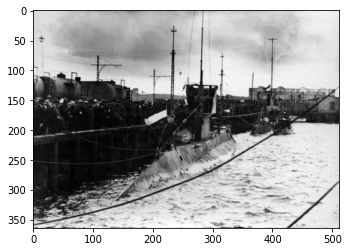

In [ ]:
# look at difficult image
im_name = "9f972770"
im = Image.open("/content/drive/MyDrive/Leonardo Training Camp/data/test/test/" + im_name + ".jpg")
plt.imshow(im)
print(categories[df_compare.loc[str(im_name + ".jpg")].majority])

### Build the final csv

In [ ]:
# Final submission dataset
df_final = df_compare.copy()
# Drop all columns except "majority" and reset index
columns_to_drop = list(df_final.columns)
columns_to_drop.pop()
df_final = df_final.drop(columns = columns_to_drop)
df_final.reset_index(inplace = True)
df_final = df_final.rename(columns = {"majority":"category_id"})

Estimate of the distribution of the labels:

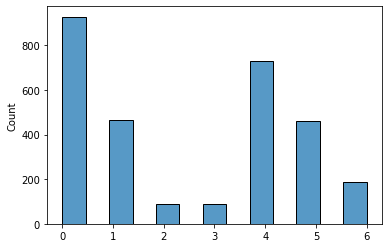

In [ ]:
sns.histplot(x = np.array(df_final.category_id))

Estimate accuracy with respect our best model (ViT)

In [ ]:
np.sum(df_compare.majority == df_vit_2.category_id) / len(df_final)

0.9874661246612466

Look at same images with the proper label:

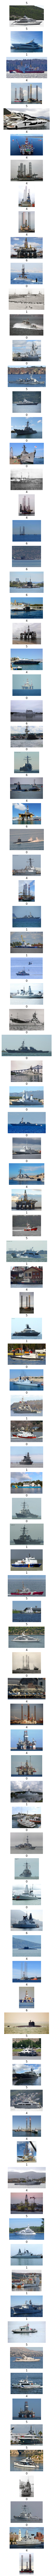

In [ ]:
# visualize the top 28 train images
plt.figure(figsize=(400,200))

for i in range(1,101):
    plt.subplot(100,1,i)
    plt.title(f'{df_final["category_id"].values[i]}')
    plt.imshow(np.array(Image.open('/content/drive/MyDrive/Leonardo Training Camp/data/test/test/'+df_final['file_name'].values[i])))
    plt.axis('off')
plt.show()

In [ ]:
# save csv for submission
df_final.to_csv("/content/drive/MyDrive/Leonardo Training Camp/submissions/ensemble_final_2.csv", index=False)